In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import io, datasets, transforms
from tqdm.notebook import tqdm

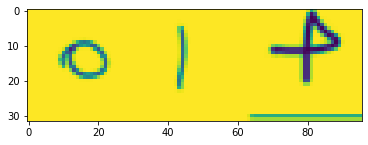

In [3]:
class ExpressionDataset(Dataset):
    """Binomial expression dataset"""
    
    def __init__(self, csv_file, root_dir):
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transforms.Compose([ 
            transforms.Resize([128//4,384//4]),
            transforms.ToTensor()
        ])
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, self.labels.iloc[idx,0])
        img = self.transform(Image.open(img_name))
        exprtype, ans = self.labels.iloc[idx,1:]
        exprtype_int = 0
        if exprtype == "infix":
            exprtype_int = 1
        elif exprtype == "postfix":
            exprtype_int = 2
        return [img, exprtype_int, ans]

dataset = ExpressionDataset(csv_file='../input/soml-hackathon/SoML-50/annotations.csv', root_dir='../input/soml-hackathon/SoML-50/data')
plt.imshow(dataset[10][0].squeeze())

In [6]:
train_set, test_set, validation_set, remainder = torch.utils.data.random_split(dataset, [20000,5000,5000,20000])
# plt.imshow(train_set[10][0].permute(1,2,0))

train_loader = DataLoader(train_set, batch_size=50, shuffle=True)
test_loader = DataLoader(test_set, batch_size=50, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=50, shuffle=True)

In [16]:
class ExpressionTypeNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.input_layer = torch.nn.Linear((128//4)*(384//4), 384)
        #self.hl1 = torch.nn.Linear(384, 14*3)
        self.hl2 = torch.nn.Linear(384, 3)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.hl2(x)
#        x = self.relu(x)
#        x = self.hl2(x)

        return x
    
    def acc(self, loader):
        total = 0
        correct = 0
        
        for images, types, answers in loader:
            batch_size = images.shape[0]
            images = images.reshape(batch_size, (128//4)*(384//4))
            output = self(images)
            
            predicted = torch.argmax(output, dim=1)
            correct += torch.sum(types == predicted)
            total += batch_size
        
        return correct/total

In [ ]:
type_net = ExpressionTypeNetwork()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(type_net.parameters(), lr=0.0001)

for epoch in range(5):
    avg_loss = 0;
    num_iters = 0;

    for images, types, answers in tqdm(train_loader):
        optimizer.zero_grad()
        batch_size = images.shape[0]
        images = images.reshape(batch_size, (128//4)*(384//4))
        output = type_net(images)
        loss = criterion(output, types)

        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
        num_iters += 1
        
    print(f"Loss: {avg_loss/num_iters}")
    print(f"Accuracy: {type_net.acc(validation_loader)}")

  0%|          | 0/200 [00:00<?, ?it/s]

Loss: 1.0050267738103866
Accuracy: 0.7487999796867371


  0%|          | 0/200 [00:00<?, ?it/s]

Loss: 0.8069082430005073
Accuracy: 0.6741999983787537


  0%|          | 0/200 [00:00<?, ?it/s]

Loss: 0.6740591798722744
Accuracy: 0.7447999715805054


  0%|          | 0/200 [00:00<?, ?it/s]

In [9]:
print(f"Final accuracy: {type_net.acc(test_loader)}")

Final accuracy: 0.7343999743461609
